In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3,4" # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')

/home/spirit/anaconda3/envs/slca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MorrisLecar(bp.NeuGroup):
  def __init__(self, size, method='rk2', **kwargs):
    super(MorrisLecar, self).__init__(size=size, **kwargs)
    # parameters
    self.V_Ca = 120.
    self.g_Ca = 4.
    self.V_K = -84
    self.g_K = 8.
    self.V_leak = -60.
    self.g_leak = 2.
    self.C = 2.
    self.V1 = -1.2
    self.V2 = 18
    self.V_th = -15


    self.V3 = 12.
    self.V4 = 17.
    self.phi = 2/3

    # variables
    self.V = bm.Variable(-40*bm.ones(self.num))
    self.W = bm.Variable(bm.zeros(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # functions
    def dV(V, t, W, input):
        M_inf = (1 / 2) * (1 + bm.tanh((V - self.V1) / self.V2))
        I_Ca = self.g_Ca * M_inf * (V - self.V_Ca)
        I_K = self.g_K * W * (V - self.V_K)
        I_Leak = self.g_leak * (V - self.V_leak)
        dVdt = (- I_Ca - I_K - I_Leak + input*10.) / self.C
        return dVdt

    def dW(W, t, V):
        tau_W = 1 / (self.phi * bm.cosh((V - self.V3) / (2 * self.V4)))
        W_inf = (1 / 2) * (1 + bm.tanh((V - self.V3) / self.V4))
        dWdt = (W_inf - W) / tau_W
        return dWdt

    self.int_V = bp.odeint(dV, method=method)
    self.int_W = bp.odeint(dW, method=method)

  def update(self, tdi):
    V = self.int_V(self.V, tdi.t, self.W, self.input, tdi.dt)
    self.W.value = self.int_W(self.W, tdi.t, self.V, tdi.dt)
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.V.value = V
    self.input[:] = 0.

In [3]:
class ML_Scale(bp.NeuGroup):
  def __init__(self, size, method='rk2', **kwargs):
    super(ML_Scale, self).__init__(size=size, **kwargs)
    # parameters
    self.V_Ca = 120./5.
    self.g_Ca = 4.
    self.V_K = -84./5.
    self.g_K = 8.
    self.V_leak = -60./5.
    self.g_leak = 2.
    self.C = 2./5.
    self.V1 = -1.2
    self.V2 = 18
    self.V_th = -15./5.

    self.V3 = 12.
    self.V4 = 17.
    self.phi = 2/3

    # variables
    self.V = bm.Variable(-40*bm.ones(self.num))
    self.W = bm.Variable(bm.zeros(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # functions
    def dV(V, t, W, input):
        M_inf = (1 / 2) * (1 + bm.tanh((V*5. - self.V1) / self.V2))
        I_Ca = self.g_Ca * M_inf * (V - self.V_Ca)
        I_K = self.g_K * W * (V - self.V_K)
        I_Leak = self.g_leak * (V - self.V_leak)
        dVdt = (- I_Ca - I_K - I_Leak + input*2.) / self.C
        return dVdt

    def dW(W, t, V):
        tau_W = 1 / (self.phi * 5. * bm.cosh((V*5. - self.V3) / (2 * self.V4)))
        W_inf = (1 / 2) * (1 + bm.tanh((V*5. - self.V3) / self.V4))
        dWdt = (W_inf - W) / tau_W
        return dWdt

    self.int_V = bp.odeint(dV, method=method)
    self.int_W = bp.odeint(dW, method=method)

  def update(self, tdi):
    V = self.int_V(self.V, tdi.t, self.W, self.input, tdi.dt)
    self.W.value = self.int_W(self.W, tdi.t, self.V, tdi.dt)
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.V.value = V
    self.input[:] = 0.

In [4]:
simulation_number = 500
model = ML_Scale(simulation_number)
input_current = bm.linspace(0.,11.,simulation_number)
I_ext_list    = np.array(input_current)
runner = bp.dyn.DSRunner(model, monitors=['spike','V'], inputs=['input',input_current],dt=0.01)
runner.run(2000.)
spike_sum = runner.mon['spike'].sum(axis=0) 

Predict 200000 steps: : 100%|██████████| 200000/200000 [01:13<00:00, 2734.70it/s]


In [5]:
print(spike_sum)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  171  296
  378  442  496  543  586  624  660  693  724  754  781  808  833  857
  880 

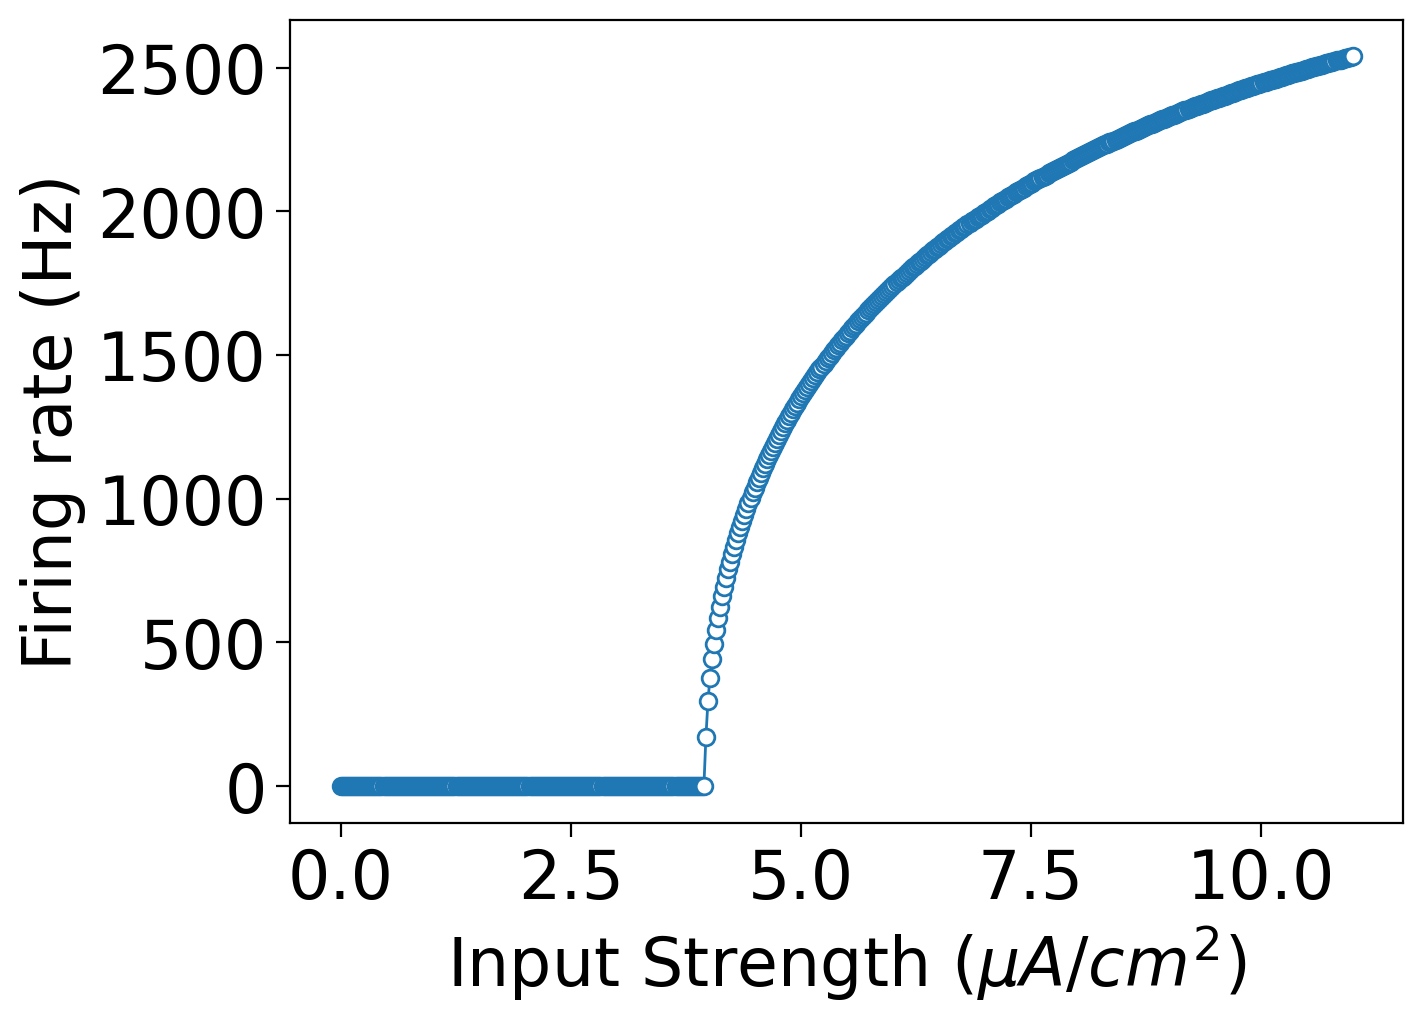

In [6]:
import matplotlib.pyplot as plt
plt_style = {
    'figure.autolayout' : True,
    'font.size' : 24,
    'lines.linewidth' : 2,
    # 'xtick.labelsize' : 'medium',
    # 'ytick.labelsize' : 'medium',
        'xtick.labelsize' : 'medium',
    'ytick.labelsize' : 'medium',
    'legend.fontsize' : 'medium',
    'axes.spines.top' : True,
    'axes.spines.right' : True,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'legend.fontsize' : 24,
    'axes.labelsize' : 24,
    'axes.titlesize' : 24,
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

firing_rate_list = spike_sum

#paint
fig, gs = bp.visualize.get_figure(1, 1, 5, 7)
firing_rate_list = bm.array(firing_rate_list)
# firing_rate_list[firing_rate_list < 10] =0
plt.plot(I_ext_list, firing_rate_list, marker = "o", markerfacecolor = 'white',linewidth =1)
plt.xlabel(r'Input Strength ($\mu A/cm^2$)')
plt.ylabel('Firing rate (Hz)')
# plt.xlim(I_ext_list[0]-0.1, I_ext_list[-1]+0.1)
# plt.ylim([-5,100])
# plt.xlim(0, 30)
plt.show()

[  8.35304086 -22.99371634  26.47121174 -11.32892117   2.74156822
   3.76677658]


<Figure size 1800x1200 with 0 Axes>

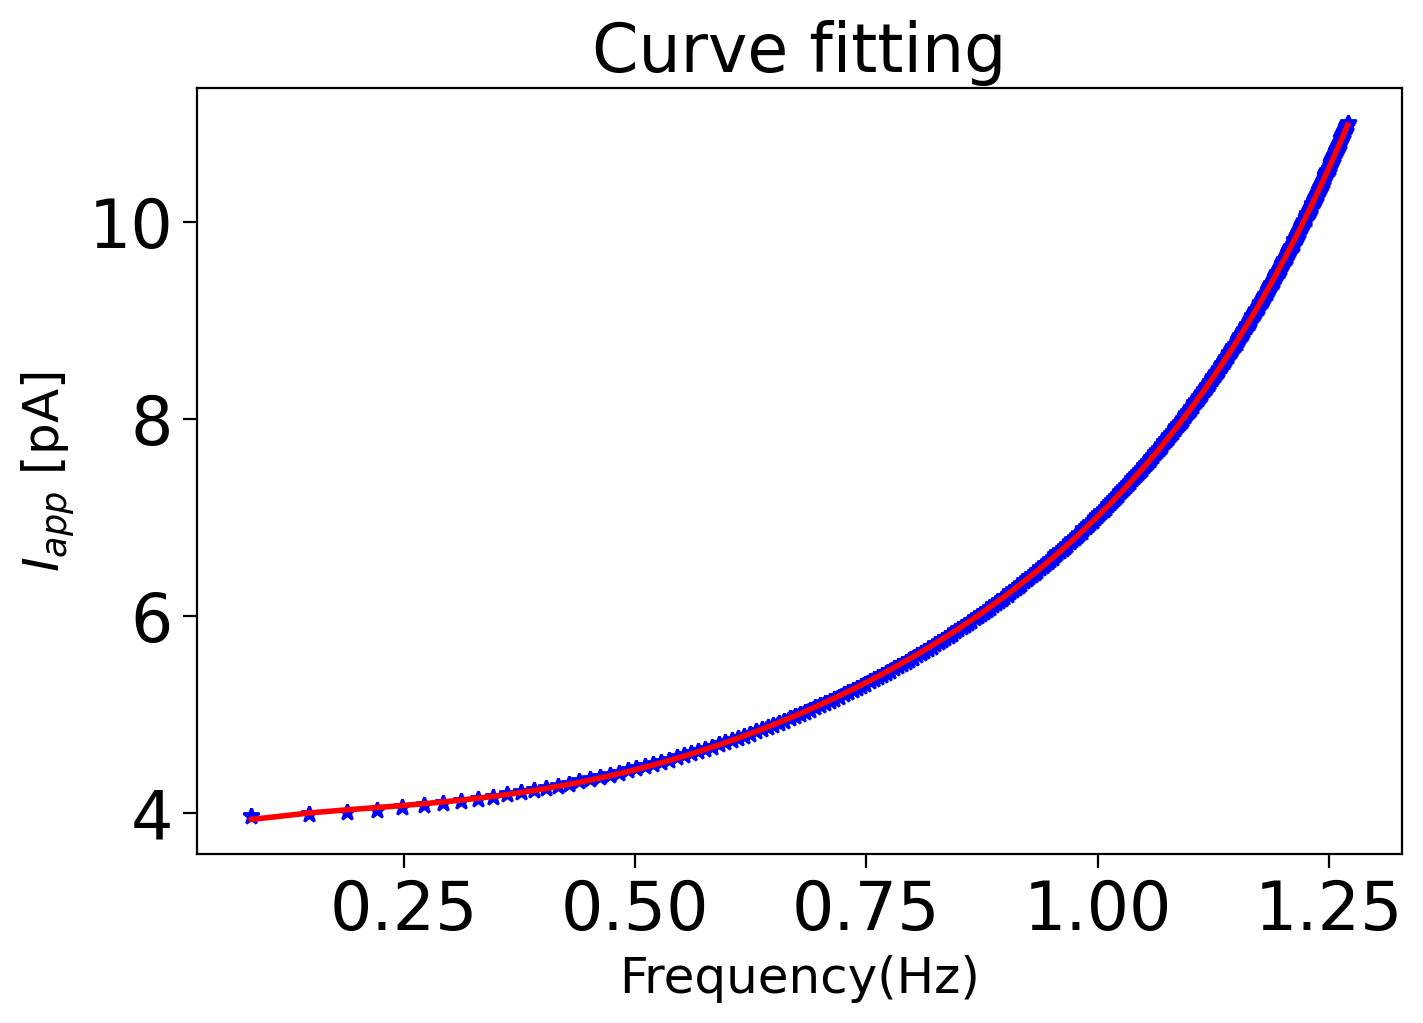

In [11]:
y = I_ext_list[firing_rate_list>0]
x = firing_rate_list[firing_rate_list>0]/2000
plt.figure(1)
coefficients = np.polyfit(x, y, deg=5)  # 2表示二次多项式
poly = np.poly1d(coefficients)

# 生成拟合曲线上的点
y_fit = poly(x)
print(coefficients)

# 绘制拟合曲线和原始数据
fig, gs = bp.visualize.get_figure(1, 1, 5, 7)
plt.plot(x, y,'b*',label='original data')
plt.plot(x, y_fit,'r',label='fitting curve')
plt.ylabel('$I_{app}$ [pA]', fontsize=18)
plt.xlabel('Frequency(Hz)', fontsize=18)
plt.title('Curve fitting')
# plt.legend()
plt.show()


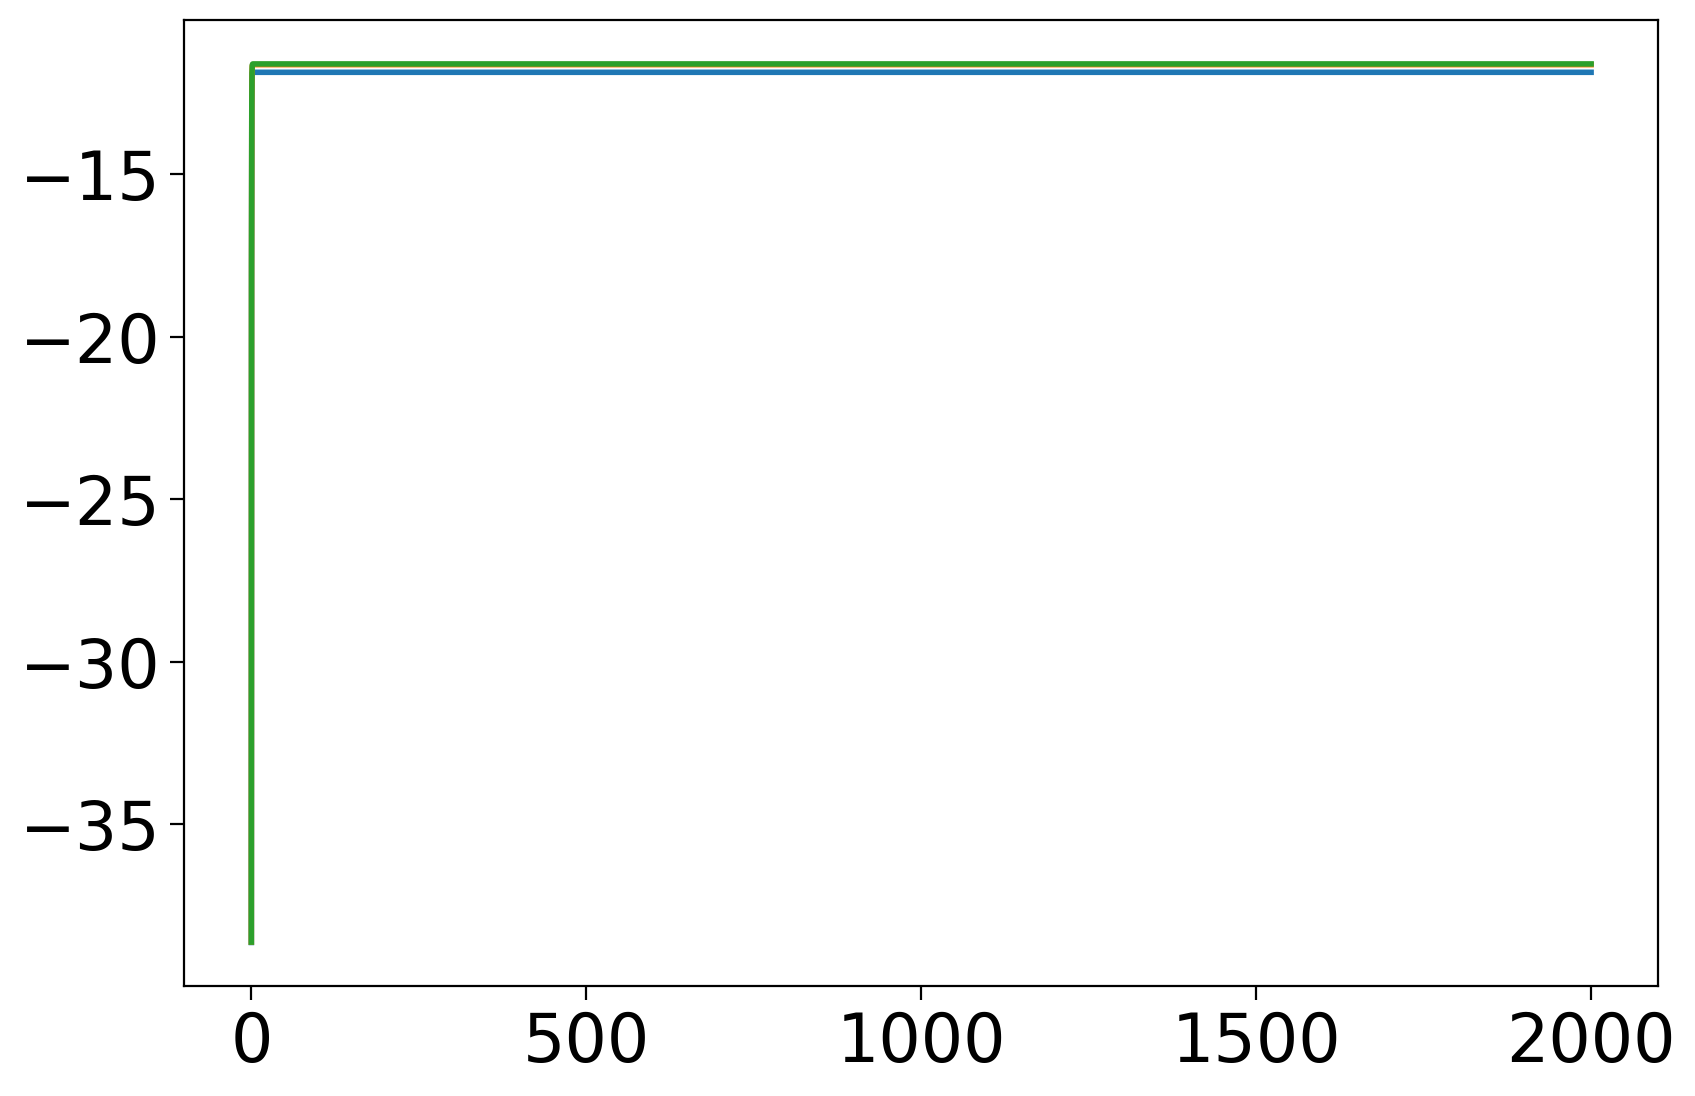

In [8]:
import matplotlib.pyplot as plt

plt.plot(runner.mon.ts, runner.mon['V'][:,1])
plt.plot(runner.mon.ts, runner.mon['V'][:,11])
plt.plot(runner.mon.ts, runner.mon['V'][:,12])

In [9]:
print(coefficients)

[  7.37751228 -14.45048426  13.55357181  -3.79610844   4.31366173]


In [10]:
print(y[0])

3.967936
